# Analysis of Crime Reports in LA

Author: Kent Hocaoglu

Course Project, UC Irvine, Math 10, Fall 24

I would like to post my notebook on the course's website. [Yes]

The data used in this project was retrieved from Data from https://catalog.data.gov/dataset/crime-data-from-2020-to-present.


## Introduction:

This project aims to apply data science techniques to analyze crime data, discover patterns, identify trends, and draw conclusions to improve public safety in the Los Angeles area.

Using a dataset containing detailed information about crime incidents such as location, time, type of crime, and victim demographics we will leverage machine learning and statistical analysis to help create predictive models to answer key questions such as: 
- What locations are most affected by crime?
- How does time and date influence crime rate?
- Are there trends in victim demographics?


### Let's begin by cleaning the data. 

First, we can get rid of the extraneous information that is not necessary for our analysis. Then, we can clean the data we want by removing the rows containing missing or filler values.

In [81]:
#import dependecies

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [82]:
clean_data = pd.read_csv('Crime_Data_from_2020_to_Present.csv')


columns_to_use = {
    'DATE OCC': 'date', 
    'TIME OCC': 'time',
    'Vict Age':'age',
    'Vict Sex':'sex',
    'LAT':'lat',
    'LON':'lon'
}

clean_data = clean_data[list(columns_to_use.keys())].rename(columns=columns_to_use)
clean_data = clean_data[(clean_data != 0).all(axis=1)]
clean_data = clean_data.dropna()

le = LabelEncoder()
clean_data['hour'] = clean_data['time'] // 100
clean_data['date'] = pd.to_datetime(clean_data['date'])
clean_data['day_of_week'] = clean_data['date'].dt.dayofweek
clean_data['month'] = clean_data['date'].dt.month

valid_labels = {'M': 'M', 'F': 'F'}
clean_data['sex'] = clean_data['sex'].map(valid_labels)
clean_data = clean_data.dropna(subset=['sex'])
clean_data['sex'] = le.fit_transform(clean_data['sex'])
clean_data.head()



,date,time,age,sex,lat,lon,hour,day_of_week,month
1,2020-02-08,1800,47,1,34.0444,-118.2628,18,5,2
3,2020-03-10,2037,19,1,34.1576,-118.4387,20,1,3
11,2020-03-01,1430,27,1,34.0881,-118.1877,14,6,3
19,2020-02-07,1615,23,0,34.1016,-118.3370,16,4,2
23,2020-07-13,2000,41,1,34.1774,-118.5387,20,0,7


### Training and Testing

Now lets split the data up into training and testing sets. We are going to use an 80:20 train-test split to ensure our model is well trained, but does not over-fit the data and can be applied to new sets of data. For now we are going to use the date and time to predict the location. For our purposes, we only care about the hour of the day that the crime occurred.

In [83]:
# Sex classification
X_classification = clean_data[['hour', 'day_of_week', 'month', 'lat', 'lon']]
y_classification = clean_data['sex']

# Age classification
X_regression = clean_data[['hour', 'day_of_week', 'month', 'lat', 'lon']]
y_regression = clean_data['age']

# Split data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)


Now let's use random forest classifier to classify the data. I chose ranodm forest classifier because we want to classify the victim's age and sex based on the other features we are given. Random forest allows us to accomplish this and scales well with large datasets making it a good choice for our purposes. 

In [84]:
# Predicting sex
clf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
clf.fit(X_train_class, y_train_class)

y_pred_class = clf.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Classification accuracy (Sex): {accuracy:.2f}")

# Predicting age
reg = RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=-1)
reg.fit(X_train_reg, y_train_reg)

y_pred_reg = reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Mean Absolute Error (Age): {mae:.2f}")

Classification accuracy (Sex): 0.58
Mean Absolute Error (Age): 11.79


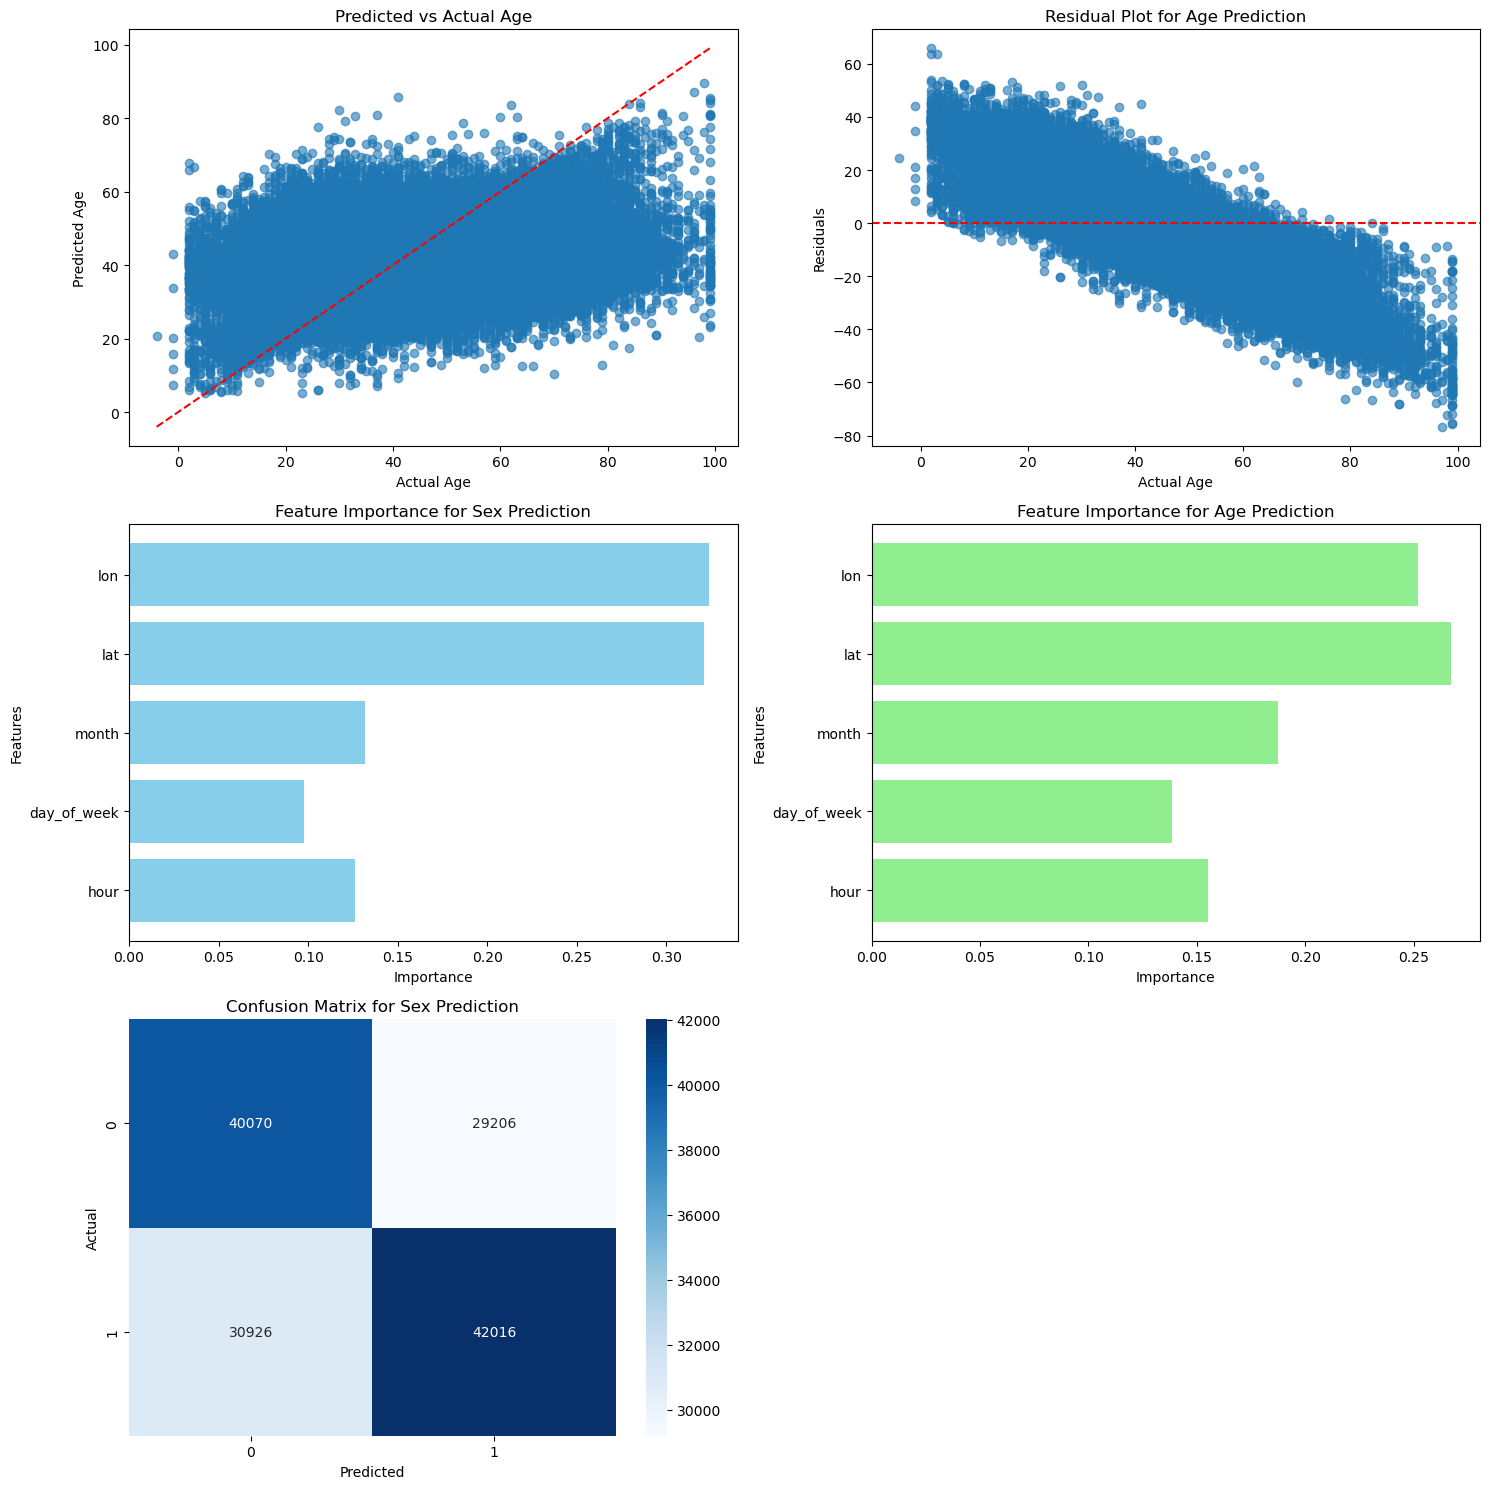

In [85]:
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Predicted vs Actual Age
axs[0, 0].scatter(y_test_reg, y_pred_reg, alpha=0.6)
axs[0, 0].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
axs[0, 0].set_title('Predicted vs Actual Age')
axs[0, 0].set_xlabel('Actual Age')
axs[0, 0].set_ylabel('Predicted Age')

# Residual Plot for Age Prediction
residuals = y_pred_reg - y_test_reg
axs[0, 1].scatter(y_test_reg, residuals, alpha=0.6)
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_title('Residual Plot for Age Prediction')
axs[0, 1].set_xlabel('Actual Age')
axs[0, 1].set_ylabel('Residuals')

# Feature Importance for Sex Prediction
importances_class = clf.feature_importances_
axs[1, 0].barh(X_classification.columns, importances_class, color='skyblue')
axs[1, 0].set_title('Feature Importance for Sex Prediction')
axs[1, 0].set_xlabel('Importance')
axs[1, 0].set_ylabel('Features')

# Feature Importance for Age Prediction
importances_reg = reg.feature_importances_  # Assuming reg is your RandomForestRegressor for age prediction
axs[1, 1].barh(X_regression.columns, importances_reg, color='lightgreen')
axs[1, 1].set_title('Feature Importance for Age Prediction')
axs[1, 1].set_xlabel('Importance')
axs[1, 1].set_ylabel('Features')

# Confusion Matrix for Sex Prediction
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, ax=axs[2, 0])
axs[2, 0].set_title('Confusion Matrix for Sex Prediction')
axs[2, 0].set_xlabel('Predicted')
axs[2, 0].set_ylabel('Actual')

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


### Model Analysis:

From the results we can see our model is a fairly good fit for the data. The prediction model for age is close to the actual actual and the residuals are not too far from the line y=0. It does seem like we could find a slightly better fit for the data because our current model for age seems to overestimate the age at higher values. If the slope of the prediction line was smaller (and the line was flatter) it seems like it would be a better fit for the data and the residuals would be smaller.

Perhaps this occured because our data mostly involved middle aged people so the model is less accurate at more extreme values. Or it could be possible that the prediction is being skewed by zeros in the dataset that were not removed during the cleaning process.

As for the sex prediciton, the heatmap shows that the true positive and true negative values are fairly high in comparison to the false positive and false nagatives. This indicates that the sex prediction model is a good fit for the data because the true values are predicted accurately. However, the values for false classifications are higher than expected. This may be an indication that the features we are using are not the best classifiers for the sex of the victim.

### Location Analysis:

I believe a good model to analyze and predict the location of the crimes is the k cluster method to determine the approzimate locations that have had the most crimes recorded.



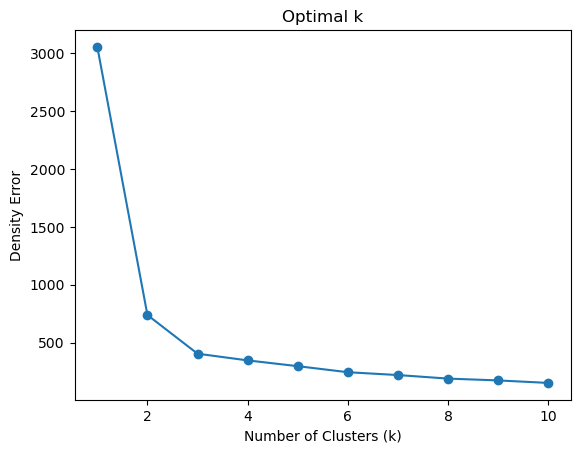

In [86]:
# First let's reassign the needed values for the current analysis 
# and seperate them into training and testing sets

X = clean_data[['hour']]

y_lat = clean_data['lat']
y_lon = clean_data['lon'] 

X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.5, random_state=2
)

X, _ = make_blobs(n_samples=200, random_state=2)

density = []

# Find the optimal k value for later use
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=2)
    kmeans.fit(X)
    density.append(kmeans.inertia_)

plt.plot(range(1, 11), density, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Density Error')
plt.title('Optimal k')
plt.show()

#### Interpretting the results:

The results show that an appropriate number of clusters for our data analysis would be 3 clusters because at k=3 the mean squared error within the clusters is low enough to suggest that they are a good fit for the data, and increasing the number of clusters does not decrease the error by a significant amount. Therefore, k=3 is the best option to avoid over-fitting our dataset, and still accurately represent and predict the data.

Centers: [[  34.20239801 -118.4811353 ]
 [  34.03393988 -118.30401373]
 [  33.77504191 -118.28615782]]


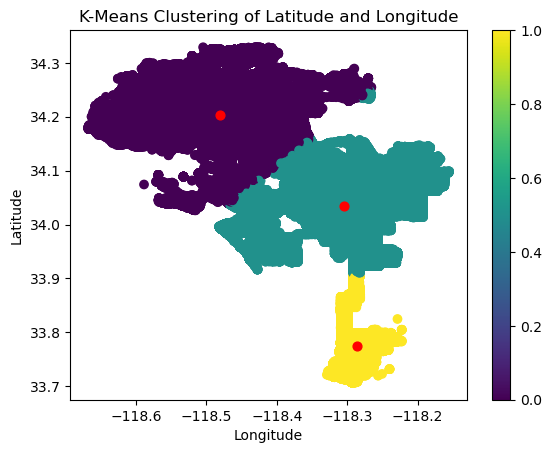

In [87]:
# Apply the k value we found earlier to plot the data into clusters

kmeans = KMeans(n_clusters=3, n_init='auto')

clean_data['cluster'] = kmeans.fit_predict(clean_data[['lat', 'lon']])
centers = kmeans.cluster_centers_
print(f'Centers: {centers}')

plt.scatter(clean_data['lon'], clean_data['lat'], c=clean_data['cluster'], cmap='viridis')
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=40, marker='o')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Latitude and Longitude')
plt.colorbar()
plt.show()

The centers of the clusters of this model are located at:
- (34.05615193, -118.29689574)
- (34.20109339, -118.48350305)
- (33.92423733, -118.3187384)

If we wanted to, we could also fit a linear regression model to these clusters to get a better representation of the variance within the cluster.

Cluster 1:
  Latitude Variance: 0.0026516
  Longitude Variance: 0.0061251

Cluster 2:
  Latitude Variance: 0.0024407
  Longitude Variance: 0.0040564

Cluster 3:
  Latitude Variance: 0.0019862
  Longitude Variance: 0.0002831



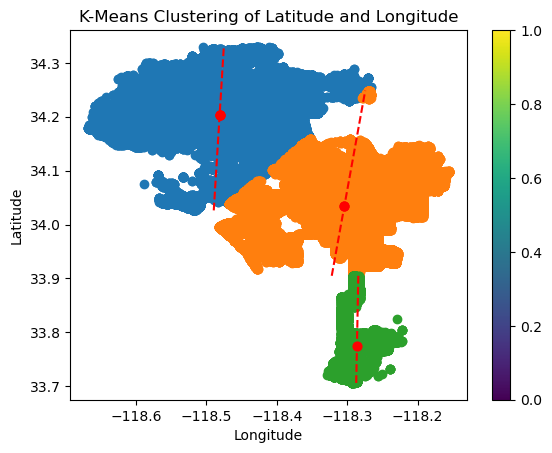

In [88]:
for cluster in range(3):

    cluster_points = clean_data[clean_data['cluster'] == cluster]

    lat_variance = np.var(cluster_points['lat'])
    lon_variance = np.var(cluster_points['lon'])
    
    print(f"Cluster {cluster + 1}:")
    print(f"  Latitude Variance: {lat_variance:.7f}")
    print(f"  Longitude Variance: {lon_variance:.7f}\n")

    # Fit linear regression for each cluster
    reg = LinearRegression()
    reg.fit(cluster_points[['lat']], cluster_points['lon'])

    plt.scatter(cluster_points['lon'], cluster_points['lat'], label=f'Cluster {cluster + 1}', cmap='viridis')
    
    lat_vals = np.linspace(cluster_points['lat'].min(), cluster_points['lat'].max(), 100)
    lon_vals = reg.predict(lat_vals.reshape(-1, 1))
    plt.plot(lon_vals, lat_vals, linestyle='--', color='red') 
    plt.scatter(centers[:, 1], centers[:, 0], c='red', s=40, marker='o')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Latitude and Longitude')
plt.colorbar()
plt.show()

#### Conclusions:
It seems that these locations were hotspots for crime occurances within LA with most crimes happening around these locations. Knowing this, we can reduce the number of crime occurances in LA or at least decrease police response times by allocating more security resources and personnel at and around the center of these clusters. This would properly position them so they are better prepared to react when an incident occurs. They would also act as a deterrant to such incidents to prevent them from happening altogether.

Another possible approach to represent this data is the K-nearest-neighbor model. Let's fit the data with this model and compare the results with the previous model.

In [89]:
X = clean_data[['hour']]
y_lon = clean_data['lon']
y_lat = clean_data['lat']
X_train, X_test, y_lon_train, y_lon_test, y_lat_train, y_lat_test = train_test_split(X, y_lon, y_lat, test_size=0.7, random_state=2)


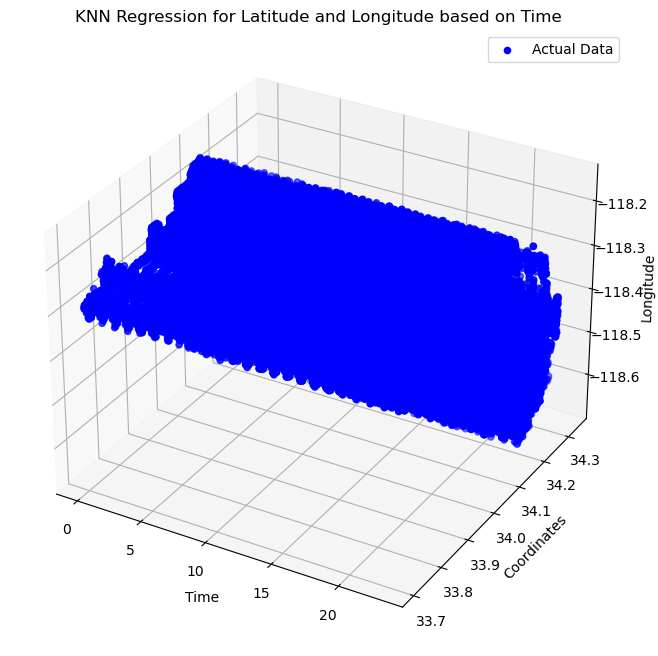

In [90]:
n = 6
knn_lon = KNeighborsRegressor(n_neighbors=n)
knn_lat = KNeighborsRegressor(n_neighbors=n)

knn_lon.fit(X_train, y_lon_train)
knn_lat.fit(X_train, y_lat_train)

clean_data['predicted_lon'] = knn_lon.predict(X)
clean_data['predicted_lat'] = knn_lat.predict(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Show actual values
ax.scatter(clean_data['hour'], clean_data['lat'], clean_data['lon'], label='Actual Data', c='blue')

ax.set_xlabel('Time')
ax.set_ylabel('Coordinates')
ax.set_zlabel('Longitude')
ax.set_title('KNN Regression for Latitude and Longitude based on Time')
ax.legend()
plt.show()

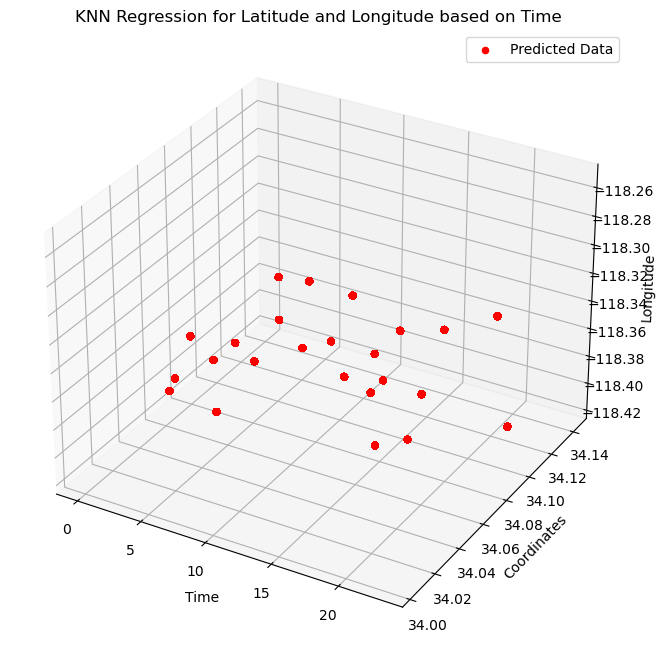

In [91]:
# Show predicted values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(clean_data['hour'], clean_data['predicted_lat'], clean_data['predicted_lon'], label='Predicted Data', c='red')
ax.set_xlabel('Time')
ax.set_ylabel('Coordinates')
ax.set_zlabel('Longitude')
ax.set_title('KNN Regression for Latitude and Longitude based on Time')
ax.legend()
plt.show()

#### Danger Score:

We will now attempt to assign a "danger score" which predicts and scores the level of danger given a time and location. Using the information we have about the longitude, latitude, and time of previous crimes, we will analyze these features and predict the likelihood (or danger) of crimes occuring given similar conditions.

We will use the clustering model and calculate the distance from the center of the clusters to assign danger based on the featrues we have chosen. We can then visualize these scores to see if they are a good fit for the data.

         lon      lat  hour  danger_score
1  -118.2628  34.0444    18     10.393107
3  -118.4387  34.1576    20      1.912551
11 -118.1877  34.0881    14      8.578740
19 -118.3370  34.1016    16     14.695316
23 -118.5387  34.1774    20      2.414178


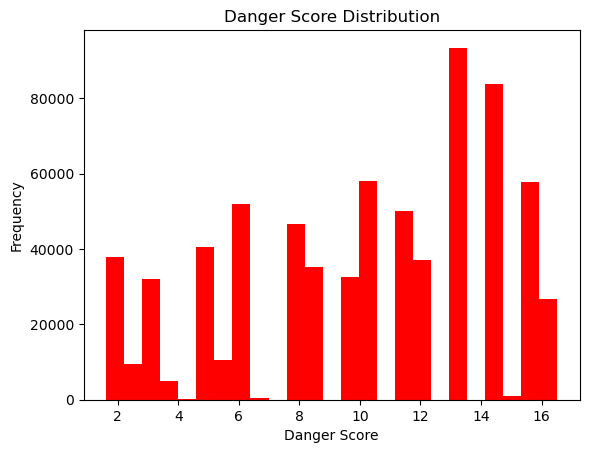

In [92]:
danger_scores = []
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=2)

# Create a cluster feature for ease of access and efficiency
clean_data['cluster'] = kmeans.fit_predict(clean_data[['lon', 'lat', 'hour']])
cluster_centers = kmeans.cluster_centers_

# Assign a danger score based on the distance to clusters
for index, row in clean_data.iterrows():
    cluster_id = row['cluster']
    cluster_center = cluster_centers[cluster_id]
    
    cluster_distance = np.linalg.norm([row['lat'] - cluster_center[1], row['lon'] - cluster_center[0], row['hour'] - cluster_center[2]])

    danger_score = np.log(cluster_distance + 1) * 10
    danger_scores.append(danger_score)

clean_data['danger_score'] = danger_scores

print(clean_data[['lon', 'lat', 'hour', 'danger_score']].head())
plt.hist(clean_data['danger_score'], bins=25, color='red')
plt.title('Danger Score Distribution')
plt.xlabel('Danger Score')
plt.ylabel('Frequency')
plt.show()


We can see the danger scores vary with there being a combination of low, medium, and high danger classifications. Let's use this new feature  to train a model to predict the danger based on the time and location.

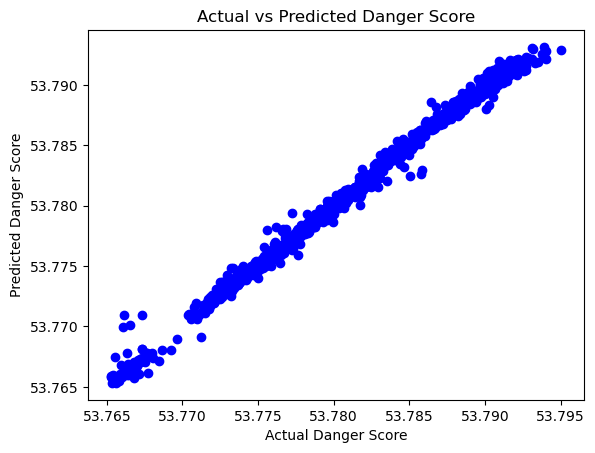

Mean Squared Error: 2.531913746393213e-07
R-squared: 0.993743266893714


In [93]:
# Here we will use a sample of the data otherwise the algorithm will take a long time to run due to the large dataset being used.

clean_data_sample = clean_data.sample(frac=0.01, random_state=3)
X = clean_data_sample[['lat', 'lon', 'hour']]
X_train, X_test = train_test_split(X, test_size=0.2, random_state=3)
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=2)
kmeans.fit(X_train)
cluster_centers = kmeans.cluster_centers_

# Function to predict the danger score given the lon, lat, and time
def predict_danger_score(row, cluster_centers):
    cluster_id = kmeans.predict([row[['lat', 'lon', 'hour']]])[0]
    cluster_center = cluster_centers[cluster_id]
    cluster_distance = np.linalg.norm([row['lat'] - cluster_center[1], row['lon'] - cluster_center[0], row['hour'] - cluster_center[2]])
    danger_score = np.log(cluster_distance + 1) * 10
    return danger_score

train_danger_scores = X_train.apply(lambda row: predict_danger_score(row, cluster_centers), axis=1)
X_train['danger_score'] = train_danger_scores

test_danger_scores = X_test.apply(lambda row: predict_danger_score(row, cluster_centers), axis=1)
X_test['danger_score'] = test_danger_scores

X_train_features = X_train[['lat', 'lon', 'hour']]
y_train = X_train['danger_score']

X_test_features = X_test[['lat', 'lon', 'hour']]
y_test = X_test['danger_score']

# To visualize and analyze the results we will use KNN regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_features, y_train)

y_pred = knn.predict(X_test_features)


plt.scatter(y_test, y_pred, c='blue')
plt.xlabel('Actual Danger Score')
plt.ylabel('Predicted Danger Score')
plt.title('Actual vs Predicted Danger Score')
plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


#### Analysis:

The model has an extremely low MSE and high R-squared value which are indicators that our model is a very good fit for the data. They may be indicitive of over-fitting despite the train-test split and randomized sample that we chose to train the model. This outcome may have been expected because the danger score was calculated from the time and location features originally and then trained on these same features.

Perhaps using new features to predict the danger score would be a mroe productive use of this model, however the dataset we chose does not have many such related features.

Nevertheless, let's use the models we have created to visualize the model as a whole: we can predict danger based on the location (longitude and latitude) and the time of day.

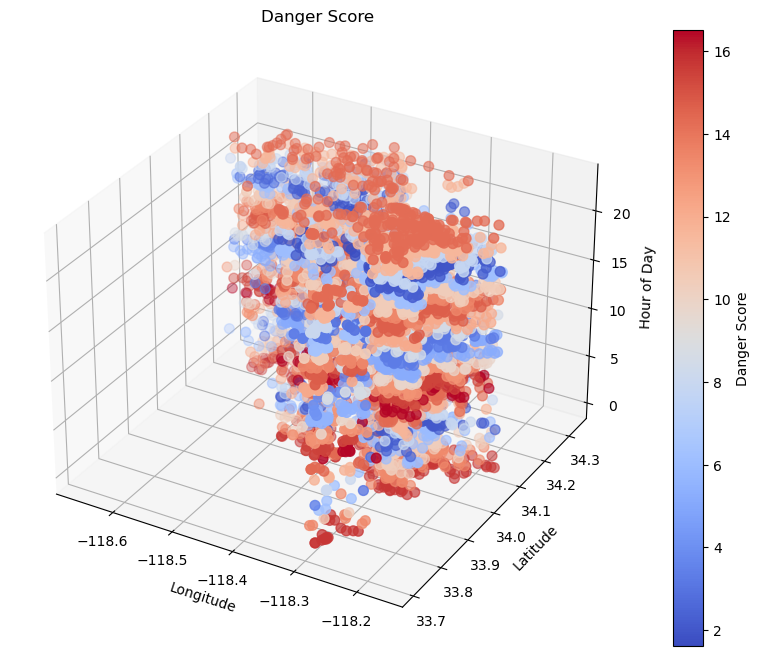

In [94]:
# Visualize using a 3D plot

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

lat = clean_data_sample['lat']
lon = clean_data_sample['lon']
hour = clean_data_sample['hour']
danger_score = clean_data_sample['danger_score']

sc = ax.scatter(lon, lat, hour, c=danger_score, cmap='coolwarm', s=50)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Hour of Day')
ax.set_title('Danger Score')

plt.colorbar(sc, label='Danger Score')

plt.show()


### Analaysis:

Using K-means clsutering and K-nearest neighbors regression we created a predictive model of danger based on spatial and temporal data of previous crime incidents.

The danger score calculation was computed from the distance away from the center of the clusters of our targetted features.

From this model we can determine that that most of these crimes have tended to occur early in the morning or late at night. The mid-day and afternoons are generally safer in comparison, and the locations are easily seen via the longitude and latitude coordinates.

This information and model could be beneficial to normal citizens or the police responsers to better prepare them for crimes before they even occur. 


### Challenges:

- One challenge encountered was ensuring that the model did not overfit or underfit, especially when dealing with large datasets. Computational time was a concern during the training and testing phases, and optimizing the model’s efficiency was necessary.

- The danger score is highly sensitive to the data used for training, so future iterations of the model may benefit from incorporating more contextual factors and refining the distance-based approach.

### Final Conclusions:

First we created a model that predicts the victims age and sex based on the other features. The analysis of this model shows that there is a slight correlation between the features and the victim's age and sex. We can determine that the correlation is not strong because the false positive and false negative rates are relatively high compared to the true positive and true negative rates. The regression of the age prediction shows similar results because the residuals are quite high and the correlation of the prediction is not very strong.

Then, we have created a predictive model of danger (crime occurance) based on the time and location of crimes reported in the past. This model could be used to help people stay safe, away from these locations at the wrong time, or they could be used to help the police respond faster and more accurately than they could previously.

For further analysis, we could implement classifications of the type of victims. Are certain types of people more likely to be victims of a crime? Is the date, time of year, or weather an important feature for our models? Are there better predictors of crime that our model is missing? These are all possible future topics of analysis.


### Takeaways

Overall, this project demonstrated the power of combining clustering techniques with regression models to predict danger scores based on spatial and temporal data, offering valuable insights into how data science can be applied in public safety and security.

